In [49]:
library(arrow)
library(bsts)
library(dplyr)
library(ggplot2)
library(magrittr) 


In [50]:
data <- read_parquet("../data/afrr_price.parquet")

data <- data[data$time_utc >= as.POSIXct("2024-11-01", tz = "UTC") & 
                data$time_utc <= as.POSIXct("2025-02-28", tz = "UTC"), ]


data$log_price_ts <- log(data$aFRR_UpCapPriceEUR + 1)


In [51]:
colnames((data))

 [1] "wind_offshore_dayahead" "wind_onshore_dayahead"  "solar_dayahead"         "aFRR_DownCapPriceEUR"   "aFRR_UpCapPriceEUR"    
 [6] "load_forecasts"         "da_price"               "prod_unbalance"         "time_utc"               "log_price_ts"          

In [ ]:
train_size <- floor(0.8 * nrow(data))
train_data <- data[1:train_size, ]
test_data <- data[(train_size+1):nrow(data), ]

y_train <- train_data$log_price_ts
y_test <- test_data$log_price_ts

X_train <- train_data %>%
  select(wind_offshore_dayahead, wind_onshore_dayahead, solar_dayahead, load_forecasts, da_price, prod_unbalance) %>%
  as.matrix()

X_test <- test_data %>%
  select(wind_offshore_dayahead, wind_onshore_dayahead, solar_dayahead, load_forecasts, da_price, prod_unbalance) %>%
  as.matrix()

sdy <- sd(y_train, na.rm = TRUE)

#ss <- AddLocalLinearTrend(list(), y_train)
#ss <- AddSeasonal(ss, y_train, nseasons = 24, season.duration = 1)
#ss <- AddSeasonal(ss, y_train, nseasons = 168, season.duration = 1)
ss <- AddAr(ss, lags = 5, sigma.prior = SdPrior(0.01 * sdy, 10))

ss <- AddSemilocalLinearTrend(ss, y_train,
  level.sigma.prior = SdPrior(0.01*sd(y_train), 1),
  slope.mean.prior = NormalPrior(0, 0.1),
  slope.ar1.prior = Ar1CoefficientPrior(0.95),
  slope.sigma.prior = SdPrior(0.01*sd(y_train), 1))

model <- bsts(y_train,
              state.specification = ss,
              X = X_train,
              niter = 1000,
              ping = 100,
              seed = 123)


Warning message:
In AddGeneralizedLocalLinearTrend(ss, y_train, level.sigma.prior = SdPrior(0.01 *  :
  AddGeneralizedLocalLinearTrend is deprecated (because it was a terrible name!). Please use AddSemilocalLinearTrend instead.


=-=-=-=-= Iteration 0 Wed Feb 19 15:13:10 2025 =-=-=-=-=
=-=-=-=-= Iteration 100 Wed Feb 19 15:13:32 2025 =-=-=-=-=
=-=-=-=-= Iteration 200 Wed Feb 19 15:13:54 2025 =-=-=-=-=
=-=-=-=-= Iteration 300 Wed Feb 19 15:14:17 2025 =-=-=-=-=
=-=-=-=-= Iteration 400 Wed Feb 19 15:14:39 2025 =-=-=-=-=
=-=-=-=-= Iteration 500 Wed Feb 19 15:15:01 2025 =-=-=-=-=
=-=-=-=-= Iteration 600 Wed Feb 19 15:15:24 2025 =-=-=-=-=
=-=-=-=-= Iteration 700 Wed Feb 19 15:15:46 2025 =-=-=-=-=
=-=-=-=-= Iteration 800 Wed Feb 19 15:16:08 2025 =-=-=-=-=
=-=-=-=-= Iteration 900 Wed Feb 19 15:16:31 2025 =-=-=-=-=


In [65]:
horizon <- 48  # Forecast 12 periods ahead
X_test <- X_train[nrow(X_train) - (horizon-1):0, ]  # Adjust as needed for actual test data

# Generate forecasts
predictions <- predict(model, 
                      horizon = horizon,  
                      newdata = X_test,
                      burn = 100,  # Discard first 100 iterations as burn-in
                      quantiles = c(0.025, 0.975))  # 95% credible intervals

# Extract results
forecasts <- predictions$mean  # Point forecasts
lower_ci <- predictions$interval[1,]  # Lower bounds
upper_ci <- predictions$interval[2,]  # Upper bounds

In [66]:
plot_data <- data.frame(
  Time = 1:horizon,
  Predicted = predictions$mean,
  Actual = y_test[1:horizon]
)

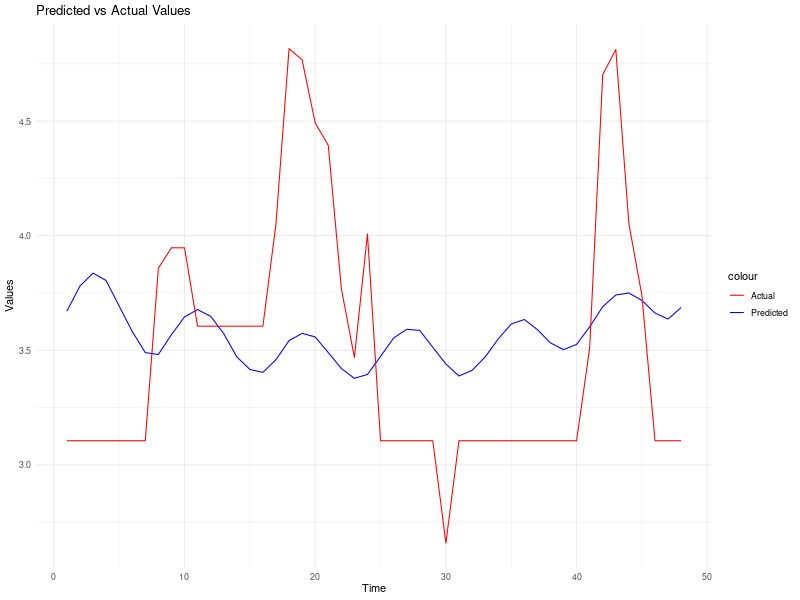

In [67]:
library(ggplot2)


ggplot(plot_data, aes(x=Time)) +
geom_line(aes(y=Predicted, color="Predicted")) +
geom_line(aes(y=Actual, color="Actual")) +
labs(x="Time", y="Values", title="Predicted vs Actual Values") +
scale_color_manual(values=c("Predicted"="blue", "Actual"="red")) +
theme_minimal()